In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'

os.environ["HF_HOME"]="~/codes/.cache/huggingface"

In [2]:
import torch
import random
import numpy as np

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds(42)

In [3]:
import matplotlib.pyplot as plt
def show_images(images, scores, test_artist, train_artists):
    n: int = len(images)
    f = plt.figure(figsize=(16, 2))
    for i in range(n):
        # Debug, plot figure
        ax = f.add_subplot(1, n, i + 1)
        if i==0:
            pass
            ax.title.set_text(test_artist)
        else:
            ax.title.set_text(str(np.round(scores[i-1], 4))+'\n'+train_artists[i-1])
            ax.axis('off')
        if images[i]==None:
            pass
        else:
            plt.imshow(images[i])

    plt.show(block=True)

In [4]:
from datasets import load_dataset

In [6]:
import pickle

In [7]:
with open('../../data/indices/5000-0.5/idx-train.pkl', 'rb')  as handle:
    idx_train = pickle.load(handle)
len(idx_train)   

5000

In [8]:
with open('../../data/indices/5000-0.5/idx-val.pkl', 'rb')  as handle:
    idx_val = pickle.load(handle)
len(idx_val)

1000

In [9]:
import pandas as pd
df = pd.read_csv('../../../../codes/celeba/data/celeba/list_eval_partition.txt', delimiter=" ", 
                 names=['path', 'split'],
                 header=None, skipinitialspace=True)
df['path'] = df.apply(lambda x: "../../../../codes/celeba/data/celeba/img_align_celeba/{}".format(x['path']), axis=1)
df.head()    

,path,split
0,../../../../codes/celeba/data/celeba/img_align...,0
1,../../../../codes/celeba/data/celeba/img_align...,0
2,../../../../codes/celeba/data/celeba/img_align...,0
3,../../../../codes/celeba/data/celeba/img_align...,0
4,../../../../codes/celeba/data/celeba/img_align...,0


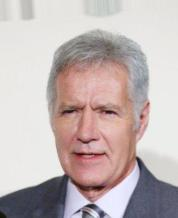

In [10]:
from datasets import Dataset, load_dataset, Image

train_dataset = Dataset.from_dict({"img": df.loc[idx_train]['path'].tolist(),
                                  }).cast_column("img", Image())
train_dataset[0]["img"]

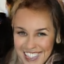

In [11]:
import pandas as pd
df = pd.DataFrame()
df['path'] = ['{}/{}.png'.format('../../saved/5000-0.5/gen', i) for i in range(1000)]

from datasets import DatasetDict, Dataset, load_dataset, Image
dataset = DatasetDict({
"train": Dataset.from_dict({
    "img": df['path'].tolist(),
}).cast_column("img", Image()),})
val_dataset = dataset["train"]
val_dataset[0]["img"]

In [12]:
idx_val[0:5]

[167013, 179842, 176165, 167714, 180120]

In [13]:
class Args():
            
    dataset_name="celeba"

    output_dir="../../saved/5000-0.5/ddpm"
    
    K=1000
    
    # project_dim=3584
    Z=65536

    # used_dim=4096
    # used_dim=8192
    # used_dim=16384
    used_dim=32768
    
    t_strategy='uniform'

    # f='mean_squared_l2_norm'
    # f='l2_norm'
    # f='loss'
   
args = Args()

In [14]:
import diffusers
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from diffusers.optimization import get_scheduler

In [15]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=1e3, eps=0.15)

2728

In [16]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=2e3, eps=0.15)

3002

In [17]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=5e3, eps=0.15)

3364

In [18]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=1e4, eps=0.15)

3638

In [19]:
# for loop over functions
scores_dot_list = []
scores_cos_list = []

for K in [10, 100, 
          # 1000
         ]:
    
    ckpt_scores_dot_list = []
    ckpt_scores_cos_list = []

    for ckpt in [
        0, 
                 2000, 4000, 6000, 
                 8000]:
        dstore_keys_list = []
        for split in range(5):
            dstore_keys = np.memmap('{}/checkpoint-{}/features-0/ddpm-train-keys-{}-{}-{}-{}-{}.npy'.format(
                args.output_dir, ckpt, split, K, args.Z, 'loss', args.t_strategy), 
                                    dtype=np.float32, 
                                    mode='r',
                                    shape=(1000, args.Z))
            dstore_keys_list.append(dstore_keys) 
            
        dstore_keys = np.vstack(dstore_keys_list)
        print(dstore_keys.shape)  
        dstore_keys = dstore_keys[:, :args.used_dim]
        print(dstore_keys.shape)
        ####        
        gen_dstore_keys = np.memmap('{}/checkpoint-{}/features-0/ddpm-gen-keys-{}-{}-{}-{}-{}.npy'.format(
                    args.output_dir, ckpt, 0, K, args.Z, 'loss', args.t_strategy), 
                                    dtype=np.float32, 
                                    mode='r',
                                    shape=(1000, args.Z))
        print(gen_dstore_keys.shape)    
        gen_dstore_keys = gen_dstore_keys[:, :args.used_dim]
        print(gen_dstore_keys.shape)
        ####
        dstore_keys = torch.from_numpy(dstore_keys).cuda()
        gen_dstore_keys = torch.from_numpy(gen_dstore_keys).cuda()
        ####
        scores = gen_dstore_keys @ dstore_keys.T
        ckpt_scores_dot_list.append(scores.cpu().numpy())
        ####
        scores = (gen_dstore_keys/torch.norm(gen_dstore_keys, dim=1).reshape(-1, 1)) @ (dstore_keys/torch.norm(dstore_keys, dim=1).reshape(-1, 1)).T
        ckpt_scores_cos_list.append(scores.cpu().numpy())
        ####
    scores_dot_list.append(ckpt_scores_dot_list)
    scores_cos_list.append(ckpt_scores_cos_list)

(5000, 65536)
(5000, 32768)
(1000, 65536)
(1000, 32768)


/tmp/ipykernel_3489/3543124190.py:40: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  gen_dstore_keys = torch.from_numpy(gen_dstore_keys).cuda()


(5000, 65536)
(5000, 32768)
(1000, 65536)
(1000, 32768)
(5000, 65536)
(5000, 32768)
(1000, 65536)
(1000, 32768)
(5000, 65536)
(5000, 32768)
(1000, 65536)
(1000, 32768)
(5000, 65536)
(5000, 32768)
(1000, 65536)
(1000, 32768)
(5000, 65536)
(5000, 32768)
(1000, 65536)
(1000, 32768)
(5000, 65536)
(5000, 32768)
(1000, 65536)
(1000, 32768)
(5000, 65536)
(5000, 32768)
(1000, 65536)
(1000, 32768)
(5000, 65536)
(5000, 32768)
(1000, 65536)
(1000, 32768)
(5000, 65536)
(5000, 32768)
(1000, 65536)
(1000, 32768)


In [20]:
with open('./gen_dot.pkl', 'wb') as handle:
    pickle.dump(scores_dot_list, handle)

In [21]:
with open('./gen_cos.pkl', 'wb') as handle:
    pickle.dump(scores_cos_list, handle)

In [22]:
# load ground truth
my_list = [
    0,1,2,3,
    4,5,6,7,
    8,9,10,11,
    12,13,14,15,
    16,17,18,19,
    20,21,22,23,
    24,25,26,27,
    28,29,30,31,
    32,33,34,35,
    36,37,38,39,
    40,41,42,43,
    44,45,46,47,
    48,49,50,51,
    52,53,54,55,
    56,57,58,59,
    60,61,62,63,
          ]

In [23]:
loss_array_list = []

for i in my_list:
    for seed in [
        0,
                 1,
                 2,
                 # 3,
                 # 4,
                ]:
        for e_seed in [
            0, 
                       1, 
                       2
                      ]:
            with open('../../saved/5000-0.5/lds-val/ddpm-sub-{}-{}/e-{}-gen.pkl'.format(i, seed, e_seed), 'rb')  as handle:
                loss_list = pickle.load(handle)
            margins = np.concatenate(loss_list, axis=-1) # -logp
            ####
            if (seed==0) and (e_seed)==0:
                loss_array = margins
            else:
                loss_array += margins
            
    loss_array = loss_array/(3*3)
    
    loss_array_list.append(loss_array)
lds_loss_array = np.stack(loss_array_list)
lds_loss_array.shape

(64, 1000, 1000)

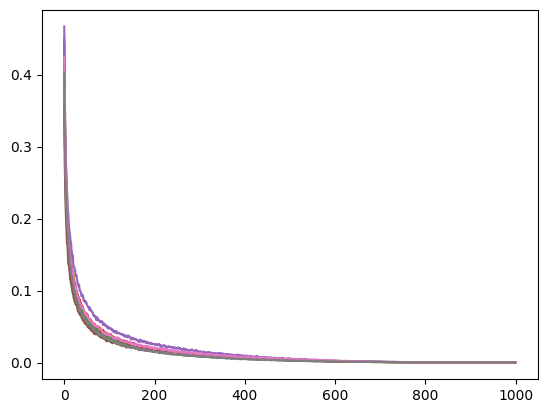

In [24]:
for i in range(1):
    for j in range(8):
        plt.plot(lds_loss_array[i, :, j], color="C{}".format(j))
    # break

In [25]:
mask_array_list = []

for i in my_list:
    # print(i)
    with open('../../data/indices/5000-0.5/lds-val/sub-idx-{}.pkl'.format(i), 'rb')  as handle:
        sub_idx_train = pickle.load(handle)
    # print(len(sub_idx_train))
    mask_array = np.in1d(idx_train, sub_idx_train)
        
    mask_array_list.append(mask_array)
    
lds_mask_array = np.stack(mask_array_list)
lds_mask_array.shape

(64, 5000)

In [26]:
lds_testset_correctness = lds_loss_array.mean(axis=1)
lds_testset_correctness.shape

(64, 1000)

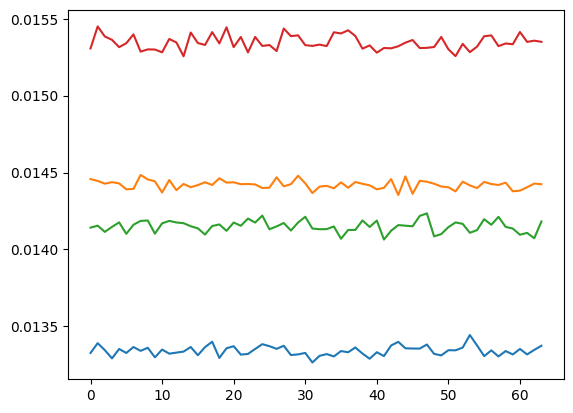

In [27]:
for j in range(4):
    plt.plot(lds_testset_correctness[:, j], color="C{}".format(j))
    # break
# plt.ylim(0.15, 0.2)

In [28]:
# compute lds for Grad dot 10
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -scores_dot_list[0][-1]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.038 (avg p value 0.484878)


In [29]:
# compute lds for Grad dot 100
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -scores_dot_list[1][-1]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.046 (avg p value 0.476289)


In [30]:
# compute lds for Grad cos 10
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -scores_cos_list[0][-1]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.039 (avg p value 0.488481)


In [31]:
# compute lds for Grad cos 100
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -scores_cos_list[1][-1]
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.045 (avg p value 0.482382)


In [32]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -np.stack(scores_dot_list[0])[1:].mean(axis=0)
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.052 (avg p value 0.472798)


In [33]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -np.stack(scores_dot_list[1])[1:].mean(axis=0)
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.045 (avg p value 0.481226)


In [34]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -np.stack(scores_cos_list[0])[1:].mean(axis=0)
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.047 (avg p value 0.479595)


In [35]:
# compute lds
from scipy.stats import spearmanr, pearsonr
####
margins = lds_testset_correctness
infl_est_ = -np.stack(scores_cos_list[1])[1:].mean(axis=0)
# infl_est_ = -tmp
preds = lds_mask_array @ infl_est_.T
####
rs = []
ps = []

for ind in range(1000):
    r, p = spearmanr(preds[:, ind], margins[:, ind])
    # r, p = pearsonr(preds[:, ind], margins[:, ind])
    rs.append(r)
    ps.append(p)
    
rs, ps = np.array(rs), np.array(ps)
print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

Correlation: 0.040 (avg p value 0.487644)


In [36]:
scores = scores_dot_list[1][-1]
scores.shape

(1000, 5000)

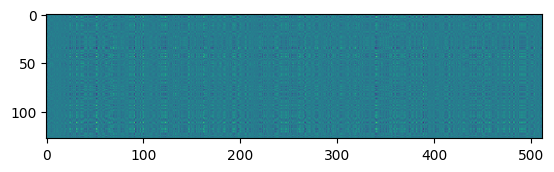

In [37]:
plt.imshow(scores[:128, 0:512])

In [38]:
# i = 13
# i = 25
i = 15
D = -scores[i]
D.shape

(5000,)

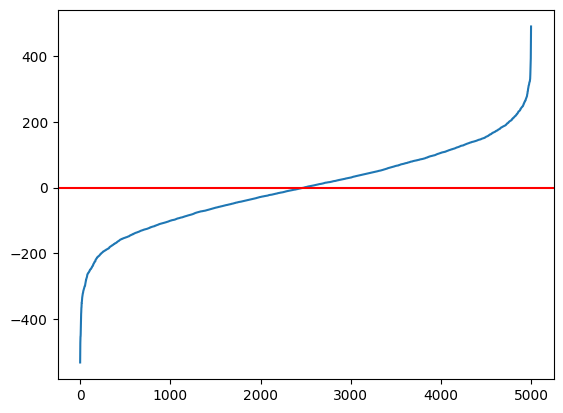

In [39]:
plt.plot(sorted(D))
plt.axhline(y=0, c='red')

In [40]:
topK = np.arange(10000)[D.argsort()[0:5]]
topK

array([1963, 3165, 1088,  941, 1511])

In [41]:
plot_images = []
plot_images.append(val_dataset[i]['img'])
for idx in topK:
    plot_images.append(train_dataset[int(idx)]['img'])

In [42]:
val_artist = ''
val_artist

''

In [43]:
train_artist = []
for i in topK:
    tmp_artist = ''
    train_artist.append(tmp_artist)
train_artist   

['', '', '', '', '']

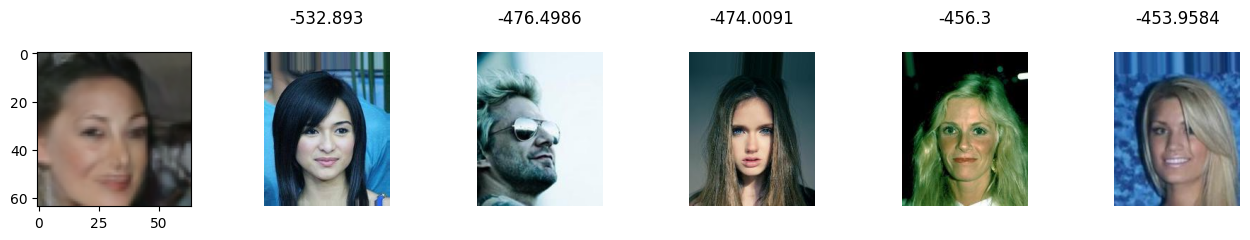

In [44]:
show_images(plot_images, D[D.argsort()[0:5]], val_artist, train_artist)